<!--
<b style='color:red'>Cell to be deleted!</b>
#### Ideas:

- Put Item-MPR in bins
- Logarithmic Transformation to Item_Visibility
- Outlet year can be ignored, because it is correlated with the 
- Or maybe, drop outlet identifier instead of all outlet features
- Maybe predict the number of items sold instead, and multiply that with item mpr
-->

## Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Structure and Content

In [2]:
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')

train_df.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

In [3]:
test_df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

In [4]:
train_df.shape

(8523, 12)

## Exploratory Data Analysis

In [5]:
# Overview of the dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [6]:
# Checking duplicates
train_df[['Item_Identifier', 'Outlet_Identifier']].duplicated().sum()

0

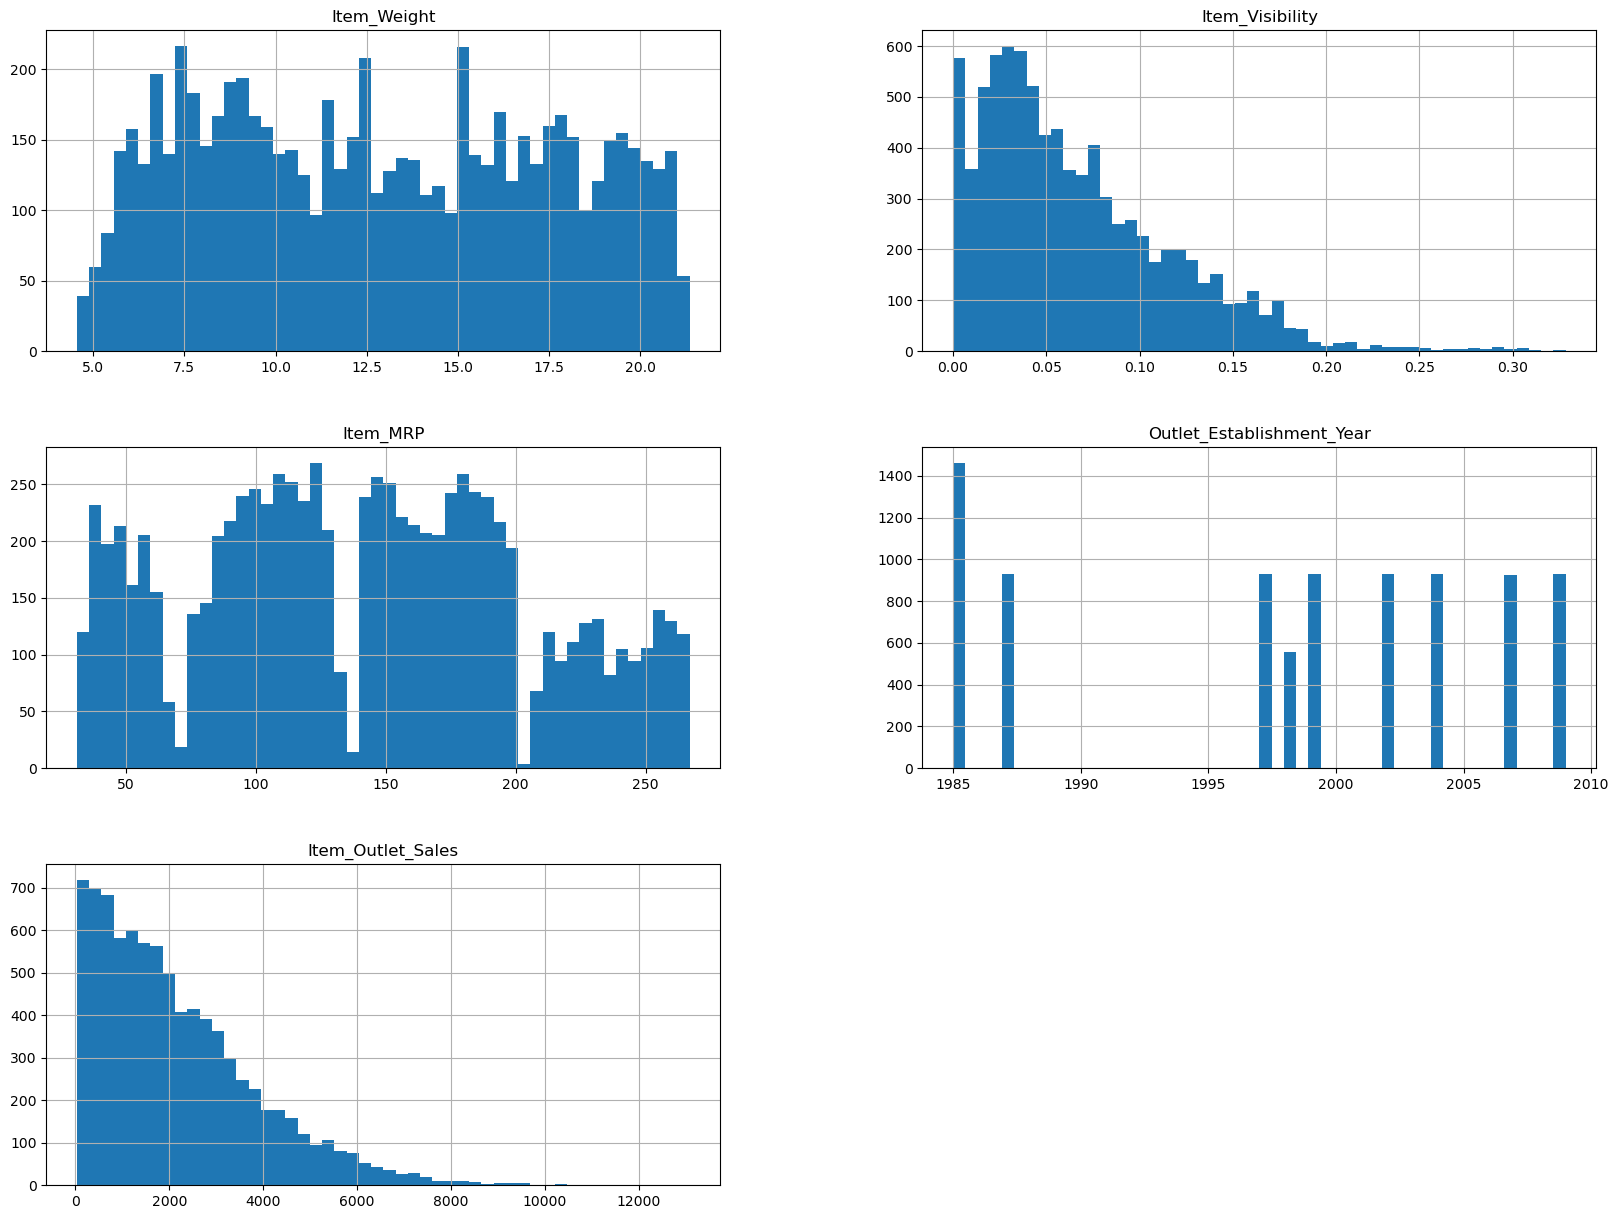

In [7]:
# Visualizing numerical variables distributions
train_df.hist(bins = 50, figsize=(20, 15))
plt.show()

## Univariate Analysis

In [8]:
# Summary statistics of numerical variables 
train_df.describe()

Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.643456         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       8.773750         0.026989    93.826500                1987.000000   
50%      12.600000         0.053931   143.012800                1999.000000   
75%      16.850000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800

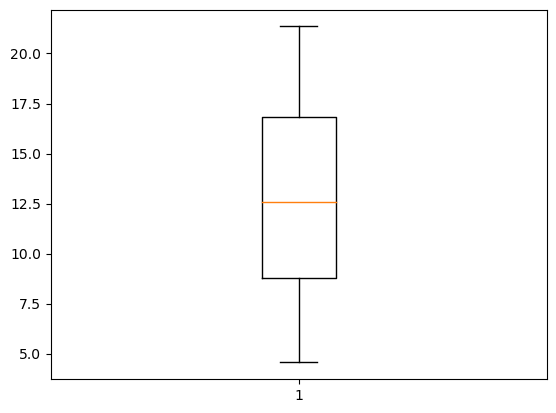

In [9]:
plt.boxplot(train_df.loc[~train_df['Item_Weight'].isna(), 'Item_Weight'])
plt.show()

In [10]:
# Percentage of null values in item_weight column
train_df.Item_Weight.isna().sum() / len(train_df)

0.1716531737651062

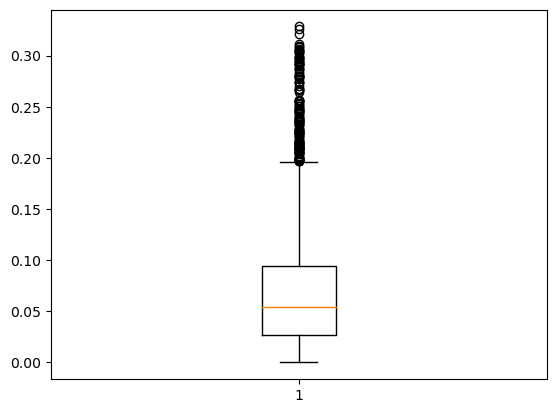

In [11]:
plt.boxplot(train_df['Item_Visibility'])
plt.show()

In [12]:
visibility_iqr = train_df['Item_Visibility'].quantile(0.75) - train_df['Item_Visibility'].quantile(0.25)
outliers_visibility_limit = train_df['Item_Visibility'].quantile(0.75) + 1.5 * visibility_iqr
print('Q3 + 1.5IQR: ', outliers_visibility_limit)
print('Percentage of outliers: ', round(100 * len(train_df[train_df['Item_Visibility'] > outliers_visibility_limit]) / len(train_df), 2), '%')

Q3 + 1.5IQR:  0.195979015
Percentage of outliers:  1.69 %


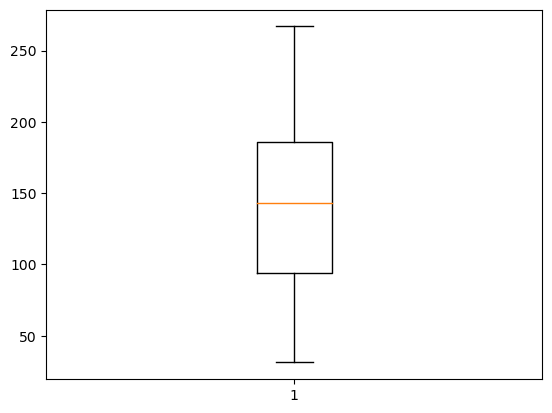

In [13]:
plt.boxplot(train_df['Item_MRP'])
plt.show()

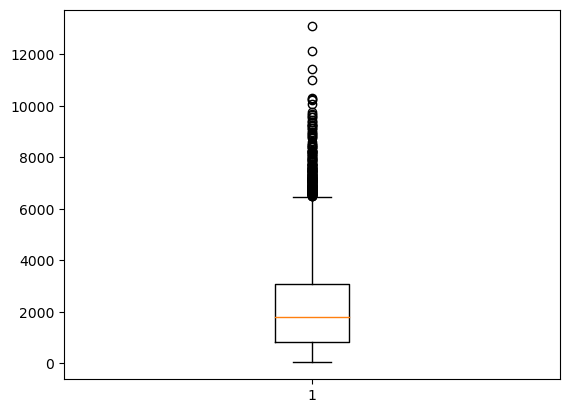

In [14]:
plt.boxplot(train_df['Item_Outlet_Sales'])
plt.show()

In [15]:
sales_iqr = train_df['Item_Outlet_Sales'].quantile(0.75) - train_df['Item_Outlet_Sales'].quantile(0.25)
outliers_sales_limit = train_df['Item_Outlet_Sales'].quantile(0.75) + 1.5 * sales_iqr
print('Q3 + 1.5IQR: ', outliers_sales_limit)
print('Percentage of outliers: ', round(100 * len(train_df[train_df['Item_Outlet_Sales'] > outliers_sales_limit]) / len(train_df), 2), '%')

Q3 + 1.5IQR:  6501.8699
Percentage of outliers:  2.18 %


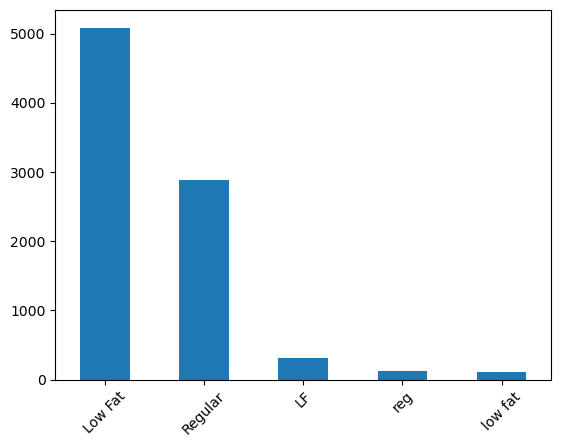

In [16]:
train_df.Item_Fat_Content.value_counts().plot.bar(rot=45)
plt.show()

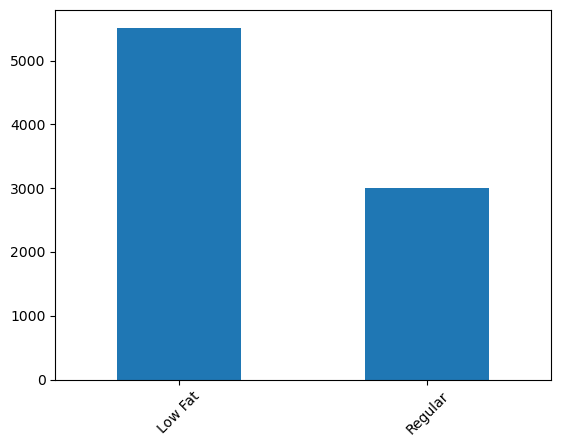

In [17]:
# There seem to be wrong data in the fat content column, let's replace the wrong ones
train_df.loc[train_df.Item_Fat_Content.isin(['LF', 'low fat']), 'Item_Fat_Content'] = 'Low Fat'
train_df.loc[train_df.Item_Fat_Content == 'reg', 'Item_Fat_Content'] = 'Regular'
train_df.Item_Fat_Content.value_counts().plot.bar(rot=45)
plt.show()

In [18]:
# There seem to be wrong data in the fat content column, let's replace the wrong ones
test_df.loc[test_df.Item_Fat_Content.isin(['LF', 'low fat']), 'Item_Fat_Content'] = 'Low Fat'
test_df.loc[test_df.Item_Fat_Content == 'reg', 'Item_Fat_Content'] = 'Regular'

In [19]:
train_df.Item_Type.value_counts(normalize=True).sort_values(ascending=False)

Fruits and Vegetables    0.144550
Snack Foods              0.140795
Household                0.106770
Frozen Foods             0.100434
Dairy                    0.080019
Canned                   0.076147
Baking Goods             0.076030
Health and Hygiene       0.061011
Soft Drinks              0.052212
Meat                     0.049865
Breads                   0.029450
Hard Drinks              0.025109
Others                   0.019829
Starchy Foods            0.017365
Breakfast                0.012906
Seafood                  0.007509
Name: Item_Type, dtype: float64

In [20]:
train_df.Outlet_Identifier.value_counts().sort_values(ascending=False)

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

In [21]:
train_df.Outlet_Size.value_counts().sort_values(ascending=False)

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [22]:
train_df.Outlet_Establishment_Year.value_counts().sort_values(ascending=False)

1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

In [23]:
train_df.Outlet_Location_Type.value_counts().sort_values(ascending=False)

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [24]:
train_df.Outlet_Type.value_counts().sort_values(ascending=False)

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

## Bivariate & Multivariate Analysis

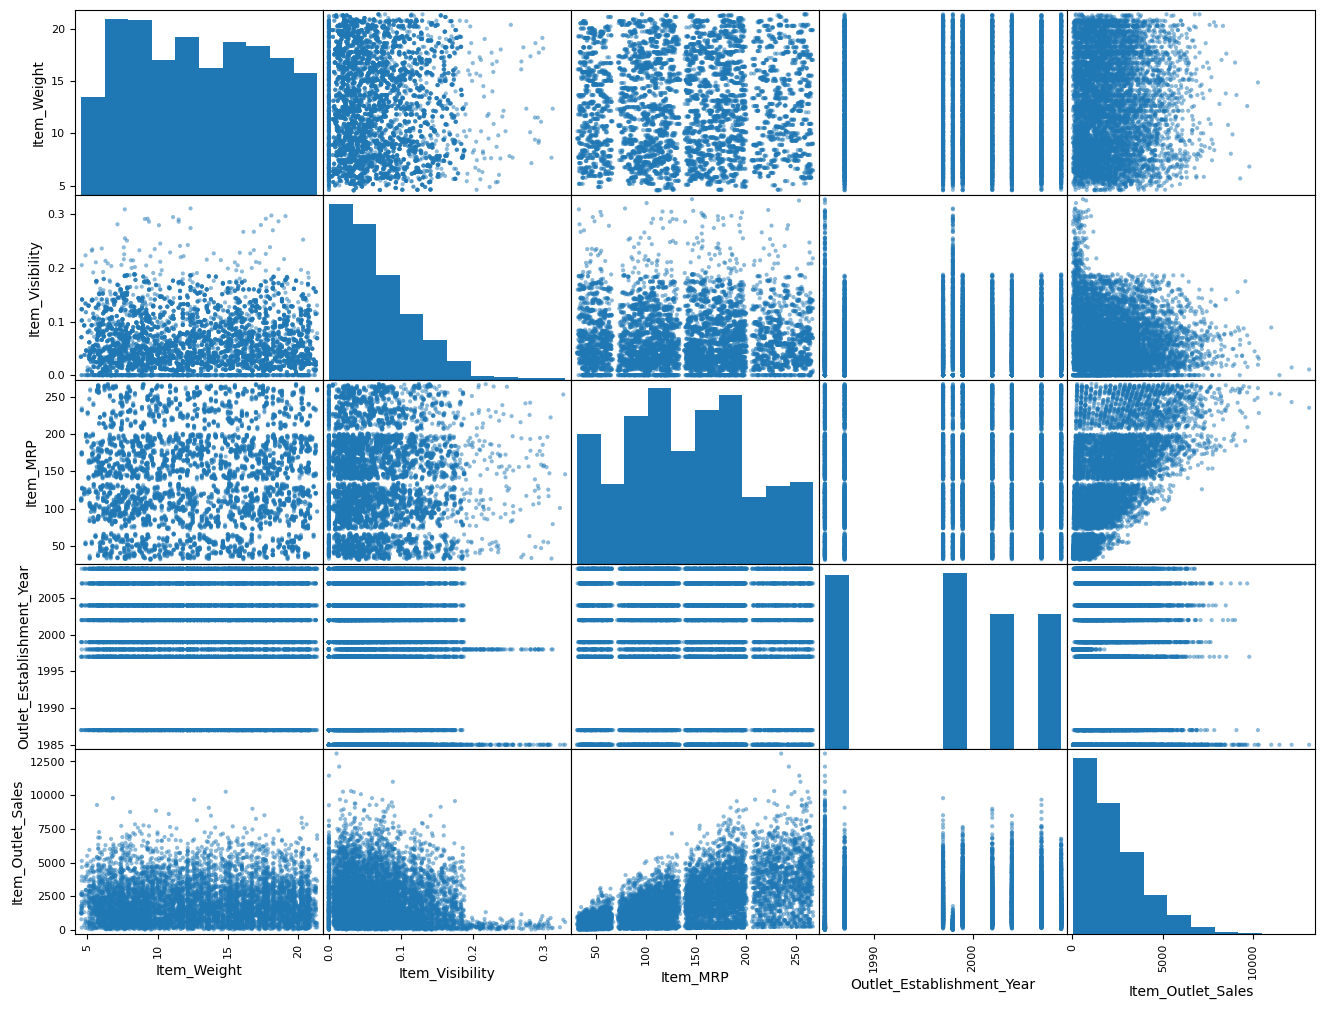

In [25]:
from pandas.plotting import scatter_matrix

scatter_matrix(train_df, figsize=(16, 12))
plt.show()

In [26]:
corr_matrix = train_df.corr().abs()

corr_matrix.sort_values(by='Item_Outlet_Sales', ascending=False)

/tmp/ipykernel_6620/3896150682.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train_df.corr().abs()


Item_Weight  Item_Visibility  Item_MRP  \
Item_Outlet_Sales             0.014123         0.128625  0.567574   
Item_MRP                      0.027141         0.001315  1.000000   
Item_Visibility               0.014048         1.000000  0.001315   
Outlet_Establishment_Year     0.011588         0.074834  0.005020   
Item_Weight                   1.000000         0.014048  0.027141   

                           Outlet_Establishment_Year  Item_Outlet_Sales  
Item_Outlet_Sales                           0.049135           1.000000  
Item_MRP                                    0.005020           0.567574  
Item_Visibility                             0.074834           0.128625  
Outlet_Establishment_Year                   1.000000           0.049135  
Item_Weight                                 0.011588           0.014123

In [27]:
q1_value = np.quantile(train_df['Item_Outlet_Sales'], 0.25)
median_value = np.median(train_df['Item_Outlet_Sales'])
q3_value = np.quantile(train_df['Item_Outlet_Sales'], 0.75)
outlier_value = 2.5 * q3_value - 1.5 * q1_value

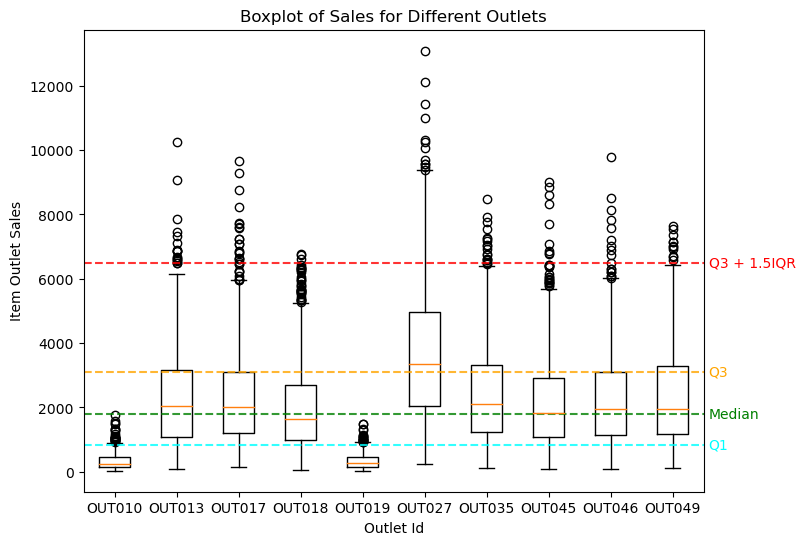

In [28]:
oid_grouped_train = train_df.groupby('Outlet_Identifier')
sales_per_oid_data = [group['Item_Outlet_Sales'].tolist() for name, group in oid_grouped_train]

plt.figure(figsize=(8, 6))
plt.boxplot(sales_per_oid_data, labels=oid_grouped_train.groups.keys())

plt.axhline(y=q1_value, color='cyan', linestyle='--', alpha=0.8)
plt.text(10.58, q1_value, 'Q1', color='cyan', va='center')

plt.axhline(y=median_value, color='green', linestyle='--', alpha=0.8)
plt.text(10.58, median_value, 'Median', color='green', va='center')

plt.axhline(y=q3_value, color='orange', linestyle='--', alpha=0.8)
plt.text(10.58, q3_value, 'Q3', color='orange', va='center')

plt.axhline(y=outlier_value, color='red', linestyle='--', alpha=0.8)
plt.text(10.58, outlier_value, 'Q3 + 1.5IQR', color='red', va='center')

plt.xlabel('Outlet Id')
plt.ylabel('Item Outlet Sales')
plt.title('Boxplot of Sales for Different Outlets')
plt.show()

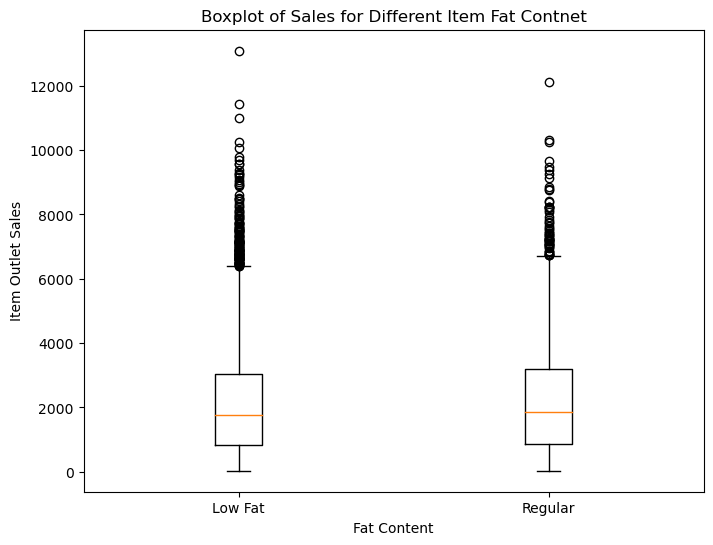

In [29]:
fat_grouped_train = train_df.groupby('Item_Fat_Content')
sales_per_fat_data = [group['Item_Outlet_Sales'].tolist() for name, group in fat_grouped_train]

plt.figure(figsize=(8, 6))
plt.boxplot(sales_per_fat_data, labels=fat_grouped_train.groups.keys())
plt.xlabel('Fat Content')
plt.ylabel('Item Outlet Sales')
plt.title('Boxplot of Sales for Different Item Fat Contnet')
plt.show()

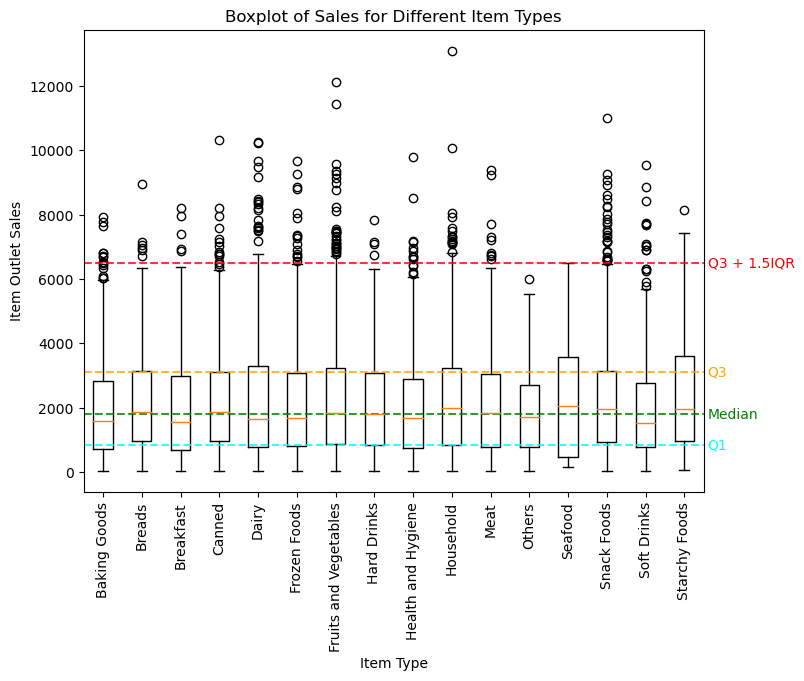

In [30]:
type_grouped_train = train_df.groupby('Item_Type')
sales_per_type_data = [group['Item_Outlet_Sales'].tolist() for name, group in type_grouped_train]

q1_value = np.quantile(train_df['Item_Outlet_Sales'], 0.25)
median_value = np.median(train_df['Item_Outlet_Sales'])
q3_value = np.quantile(train_df['Item_Outlet_Sales'], 0.75)
outlier_value = 2.5 * q3_value - 1.5 * q1_value

plt.figure(figsize=(8, 6))
plt.boxplot(sales_per_type_data, labels=type_grouped_train.groups.keys())

plt.axhline(y=q1_value, color='cyan', linestyle='--', alpha=0.8,)
plt.text(16.6, q1_value, 'Q1', color='cyan', va='center')

plt.axhline(y=median_value, color='green', linestyle='--', alpha=0.8)
plt.text(16.6, median_value, 'Median', color='green', va='center')

plt.axhline(y=q3_value, color='orange', linestyle='--', alpha=0.8)
plt.text(16.6, q3_value, 'Q3', color='orange', va='center')

plt.axhline(y=outlier_value, color='red', linestyle='--', alpha=0.8)
plt.text(16.6, outlier_value, 'Q3 + 1.5IQR', color='red', va='center')

plt.xlabel('Item Type')
plt.xticks(rotation=90)
plt.ylabel('Item Outlet Sales')
plt.title('Boxplot of Sales for Different Item Types')
plt.show()

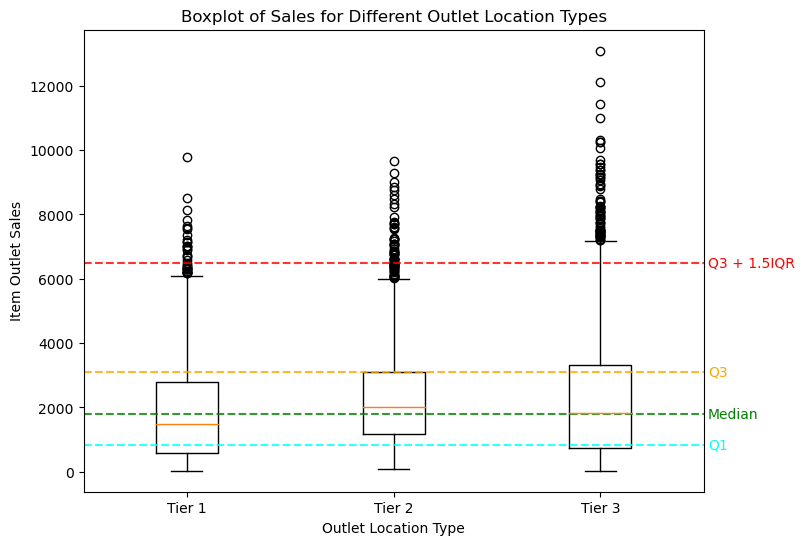

In [31]:
loc_grouped_train = train_df.groupby('Outlet_Location_Type')
sales_per_loc_data = [group['Item_Outlet_Sales'].tolist() for name, group in loc_grouped_train]

plt.figure(figsize=(8, 6))
plt.boxplot(sales_per_loc_data, labels=loc_grouped_train.groups.keys())

q1_value = np.quantile(train_df['Item_Outlet_Sales'], 0.25)
median_value = np.median(train_df['Item_Outlet_Sales'])
q3_value = np.quantile(train_df['Item_Outlet_Sales'], 0.75)
outlier_value = 2.5 * q3_value - 1.5 * q1_value

plt.axhline(y=q1_value, color='cyan', linestyle='--', alpha=0.8,)
plt.text(3.52, q1_value, 'Q1', color='cyan', va='center')

plt.axhline(y=median_value, color='green', linestyle='--', alpha=0.8)
plt.text(3.52, median_value, 'Median', color='green', va='center')

plt.axhline(y=q3_value, color='orange', linestyle='--', alpha=0.8)
plt.text(3.52, q3_value, 'Q3', color='orange', va='center')

plt.axhline(y=outlier_value, color='red', linestyle='--', alpha=0.8)
plt.text(3.52, outlier_value, 'Q3 + 1.5IQR', color='red', va='center')

plt.xlabel('Outlet Location Type')
plt.ylabel('Item Outlet Sales')
plt.title('Boxplot of Sales for Different Outlet Location Types')
plt.show()

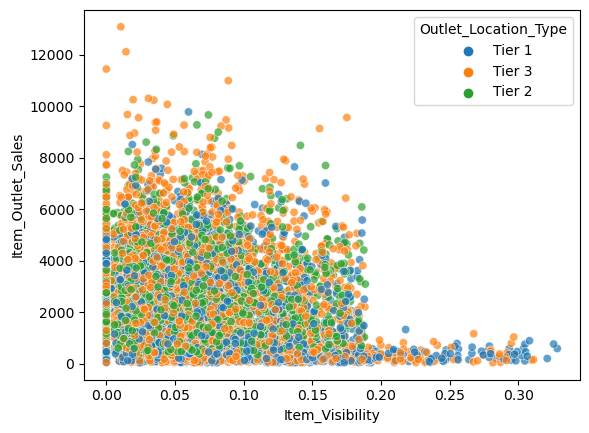

In [32]:
sns.scatterplot(x='Item_Visibility', y='Item_Outlet_Sales', data=train_df, hue='Outlet_Location_Type', alpha=0.7)
plt.show()

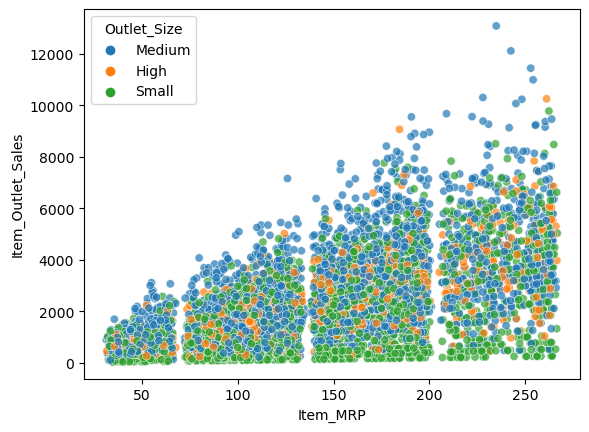

In [33]:
import seaborn as sns
sns.scatterplot(x='Item_MRP', y='Item_Outlet_Sales', data=train_df, hue='Outlet_Size', alpha=0.7)
plt.show()

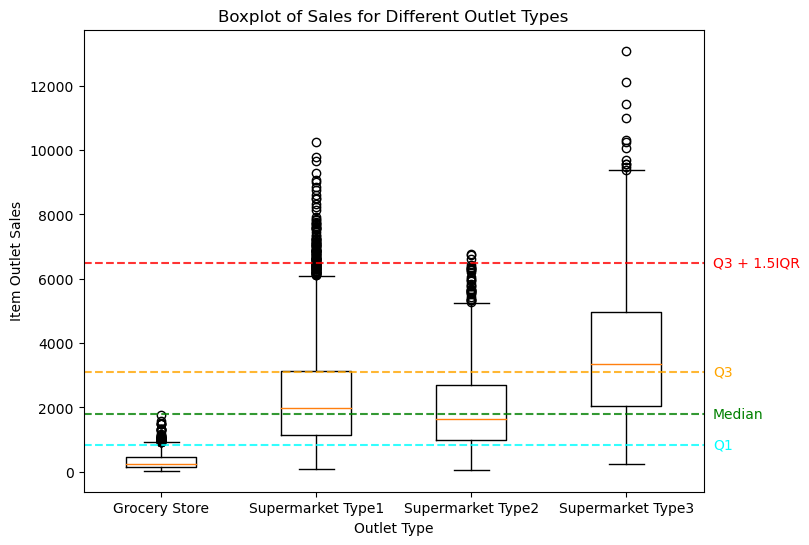

In [34]:
otype_grouped_train = train_df.groupby('Outlet_Type')
sales_per_otype_data = [group['Item_Outlet_Sales'].tolist() for name, group in otype_grouped_train]

plt.figure(figsize=(8, 6))
plt.boxplot(sales_per_otype_data, labels=otype_grouped_train.groups.keys())

q1_value = np.quantile(train_df['Item_Outlet_Sales'], 0.25)
median_value = np.median(train_df['Item_Outlet_Sales'])
q3_value = np.quantile(train_df['Item_Outlet_Sales'], 0.75)
outlier_value = 2.5 * q3_value - 1.5 * q1_value

plt.axhline(y=q1_value, color='cyan', linestyle='--', alpha=0.8)
plt.text(4.56, q1_value, 'Q1', color='cyan', va='center')

plt.axhline(y=median_value, color='green', linestyle='--', alpha=0.8)
plt.text(4.56, median_value, 'Median', color='green', va='center')

plt.axhline(y=q3_value, color='orange', linestyle='--', alpha=0.8)
plt.text(4.56, q3_value, 'Q3', color='orange', va='center')

plt.axhline(y=outlier_value, color='red', linestyle='--', alpha=0.8)
plt.text(4.56, outlier_value, 'Q3 + 1.5IQR', color='red', va='center')

plt.xlabel('Outlet Type')
plt.ylabel('Item Outlet Sales')
plt.title('Boxplot of Sales for Different Outlet Types')
plt.show()

## Missing Value Treatment

<AxesSubplot: >

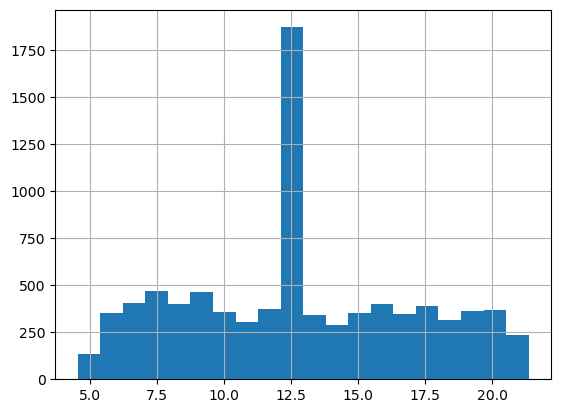

In [35]:
from sklearn.impute import SimpleImputer

# Replace mising values in weight column with the mean
imp = SimpleImputer(strategy='median')
train_df['Item_Weight'] = imp.fit_transform(train_df['Item_Weight'].values.reshape(-1, 1))
test_df['Item_Weight'] = imp.fit_transform(test_df['Item_Weight'].values.reshape(-1, 1))
train_df['Item_Weight'].hist(bins=20)

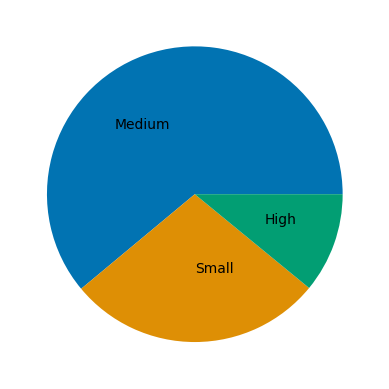

In [36]:
from sklearn.impute import SimpleImputer

# Replace mising values in weight column with the mean
imp = SimpleImputer(strategy='most_frequent')
train_df['Outlet_Size'] = imp.fit_transform(train_df['Outlet_Size'].values.reshape(-1, 1))
test_df['Outlet_Size'] = imp.fit_transform(test_df['Outlet_Size'].values.reshape(-1, 1))

outlet_size_counts = train_df['Outlet_Size'].value_counts()
colors = sns.color_palette('colorblind')[0:3]
plt.pie(outlet_size_counts, labels=outlet_size_counts.index, colors= colors, labeldistance=0.5)
plt.show()

In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## Feature Engineering

In [38]:
current_year = 2023
train_df['Outlet_Age'] = current_year - train_df['Outlet_Establishment_Year']
test_df['Outlet_Age'] = current_year - test_df['Outlet_Establishment_Year']
train_df

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0              FDA15        9.300          Low Fat         0.016047   
1              DRC01        5.920          Regular         0.019278   
2              FDN15       17.500          Low Fat         0.016760   
3              FDX07       19.200          Regular         0.000000   
4              NCD19        8.930          Low Fat         0.000000   
...              ...          ...              ...              ...   
8518           FDF22        6.865          Low Fat         0.056783   
8519           FDS36        8.380          Regular         0.046982   
8520           NCJ29       10.600          Low Fat         0.035186   
8521           FDN46        7.210          Regular         0.145221   
8522           DRG01       14.800          Low Fat         0.044878   

                  Item_Type  Item_MRP Outlet_Identifier  \
0                     Dairy  249.8092            OUT049   
1               Soft Drinks   48.2692            OUT018   
2                      Meat  141.6180            OUT049   
3     Fruits and Vegetables  182.0950            OUT010   
4                 Household   53.8614            OUT013   
...                     ...       ...               ...   
8518            Snack Foods  214.5218            OUT013   
8519           Baking Goods  108.1570            OUT045   
8520     Health and Hygiene   85.1224            OUT035   
8521            Snack Foods  103.1332            OUT018   
8522            Soft Drinks   75.4670            OUT046   

      Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                          1999      Medium               Tier 1   
1                          2009      Medium               Tier 3   
2                          1999      Medium               Tier 1   
3                          1998      Medium               Tier 3   
4                          1987        High               Tier 3   
...                         ...         ...                  ...   
8518                       1987        High               Tier 3   
8519                       2002      Medium               Tier 2   
8520                       2004       Small               Tier 2   
8521                       2009      Medium               Tier 3   
8522                       1997       Small               Tier 1   

            Outlet_Type  Item_Outlet_Sales  Outlet_Age  
0     Supermarket Type1          3735.1380          24  
1     Supermarket Type2           443.4228          14  
2     Supermarket Type1          2097.2700          24  
3         Grocery Store           732.3800          25  
4     Supermarket Type1           994.7052          36  
...                 ...                ...         ...  
8518  Supermarket Type1          2778.3834          36  
8519  Supermarket Type1           549.2850          21  
8520  Supermarket Type1          1193.1136          19  
8521  Supermarket Type2          1845.5976          14  
8522  Supermarket Type1           765.6700          26  

[8523 rows x 13 columns]

## Encoding Categorical Variables

In [40]:
ordinal_columns = ['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type']
print(train_df[ordinal_columns].head())

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder(categories=[
                        ['Low Fat', 'Regular'], # Item_Fat_Content
                        ['Small', 'Medium', 'High'], # Outlet_Size
                        ['Tier 1', 'Tier 2', 'Tier 3'], # Outlet_Location_Type
                    ])
train_df[ordinal_columns] = ordinal_encoder.fit_transform(train_df[ordinal_columns])
test_df[ordinal_columns] = ordinal_encoder.fit_transform(test_df[ordinal_columns])
train_df[ordinal_columns].head()

  Item_Fat_Content Outlet_Size Outlet_Location_Type
0          Low Fat      Medium               Tier 1
1          Regular      Medium               Tier 3
2          Low Fat      Medium               Tier 1
3          Regular      Medium               Tier 3
4          Low Fat        High               Tier 3


Item_Fat_Content  Outlet_Size  Outlet_Location_Type
0               0.0          1.0                   0.0
1               1.0          1.0                   2.0
2               0.0          1.0                   0.0
3               1.0          1.0                   2.0
4               0.0          2.0                   2.0

In [41]:
train_df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Outlet_Age'],
      dtype='object')

In [42]:
onehot_columns = ['Item_Type', 'Outlet_Identifier', 'Outlet_Type']

from sklearn.preprocessing import OneHotEncoder

onehotencoder = OneHotEncoder()
onehot_array = onehotencoder.fit_transform(train_df[onehot_columns]).toarray()
onehotencoding_data = pd.DataFrame(onehot_array, columns=[category for categories in onehotencoder.categories_ for category in categories])
train_df = train_df.join(onehotencoding_data)

onehot_array_test = onehotencoder.fit_transform(test_df[onehot_columns]).toarray()
onehotencoding_data_test = pd.DataFrame(onehot_array_test, columns=[category for categories in onehotencoder.categories_ for category in categories])
test_df = test_df.join(onehotencoding_data_test)

train_df.drop(onehot_columns, axis=1, inplace=True)
train_df

Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0              FDA15        9.300               0.0         0.016047   
1              DRC01        5.920               1.0         0.019278   
2              FDN15       17.500               0.0         0.016760   
3              FDX07       19.200               1.0         0.000000   
4              NCD19        8.930               0.0         0.000000   
...              ...          ...               ...              ...   
8518           FDF22        6.865               0.0         0.056783   
8519           FDS36        8.380               1.0         0.046982   
8520           NCJ29       10.600               0.0         0.035186   
8521           FDN46        7.210               1.0         0.145221   
8522           DRG01       14.800               0.0         0.044878   

      Item_MRP  Outlet_Establishment_Year  Outlet_Size  Outlet_Location_Type  \
0     249.8092                       1999          1.0                   0.0   
1      48.2692                       2009          1.0                   2.0   
2     141.6180                       1999          1.0                   0.0   
3     182.0950                       1998          1.0                   2.0   
4      53.8614                       1987          2.0                   2.0   
...        ...                        ...          ...                   ...   
8518  214.5218                       1987          2.0                   2.0   
8519  108.1570                       2002          1.0                   1.0   
8520   85.1224                       2004          0.0                   1.0   
8521  103.1332                       2009          1.0                   2.0   
8522   75.4670                       1997          0.0                   0.0   

      Item_Outlet_Sales  Outlet_Age  ...  OUT019  OUT027  OUT035  OUT045  \
0             3735.1380          24  ...     0.0     0.0     0.0     0.0   
1              443.4228          14  ...     0.0     0.0     0.0     0.0   
2             2097.2700          24  ...     0.0     0.0     0.0     0.0   
3              732.3800          25  ...     0.0     0.0     0.0     0.0   
4              994.7052          36  ...     0.0     0.0     0.0     0.0   
...                 ...         ...  ...     ...     ...     ...     ...   
8518          2778.3834          36  ...     0.0     0.0     0.0     0.0   
8519           549.2850          21  ...     0.0     0.0     0.0     1.0   
8520          1193.1136          19  ...     0.0     0.0     1.0     0.0   
8521          1845.5976          14  ...     0.0     0.0     0.0     0.0   
8522           765.6700          26  ...     0.0     0.0     0.0     0.0   

      OUT046  OUT049  Grocery Store  Supermarket Type1  Supermarket Type2  \
0        0.0     1.0            0.0                1.0                0.0   
1        0.0     0.0            0.0                0.0                1.0   
2        0.0     1.0            0.0                1.0                0.0   
3        0.0     0.0            1.0                0.0                0.0   
4        0.0     0.0            0.0                1.0                0.0   
...      ...     ...            ...                ...                ...   
8518     0.0     0.0            0.0                1.0                0.0   
8519     0.0     0.0            0.0                1.0                0.0   
8520     0.0     0.0            0.0                1.0                0.0   
8521     0.0     0.0            0.0                0.0                1.0   
8522     1.0     0.0            0.0                1.0                0.0   

      Supermarket Type3  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
...                 ...  
8518                0.0  
8519                0.0  
8520                0.0  
8521                0.0  
8522                0.0  

[8523 rows x 40 columns]

In [43]:
train_df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_MRP', 'Outlet_Establishment_Year', 'Outlet_Size',
       'Outlet_Location_Type', 'Item_Outlet_Sales', 'Outlet_Age',
       'Baking Goods', 'Breads', 'Breakfast', 'Canned', 'Dairy',
       'Frozen Foods', 'Fruits and Vegetables', 'Hard Drinks',
       'Health and Hygiene', 'Household', 'Meat', 'Others', 'Seafood',
       'Snack Foods', 'Soft Drinks', 'Starchy Foods', 'OUT010', 'OUT013',
       'OUT017', 'OUT018', 'OUT019', 'OUT027', 'OUT035', 'OUT045', 'OUT046',
       'OUT049', 'Grocery Store', 'Supermarket Type1', 'Supermarket Type2',
       'Supermarket Type3'],
      dtype='object')

## Modeling

In [44]:
train_prepared = train_df.drop(['Item_Identifier', 'Outlet_Establishment_Year', 'Item_Outlet_Sales'], axis = 1)
train_labels = train_df['Item_Outlet_Sales']

def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, train_prepared, train_labels, error_score='raise',
                            scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [1152.86344422 1122.50975056 1114.64376369 1130.16020894 1143.02959422]
Mean: 1132.6413523273234
Standard deviation: 13.7809084900011


In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

forest_reg = RandomForestRegressor()
forest_scores = cross_val_score(forest_reg, train_prepared, train_labels,
                            scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [1144.83900109 1133.46482669 1135.59041723 1136.75837034 1137.35151102]
Mean: 1137.6008252746146
Standard deviation: 3.855160224672298


## Hyperparameter Tuning

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {'n_estimators': [150, 155, 160, 180], 'max_features': [16, 18, 20, 22]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, verbose=3)
grid_search.fit(train_prepared, train_labels)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END max_features=16, n_estimators=150;, score=(train=-173357.301, test=-1269569.245) total time=   2.0s
[CV 2/5] END max_features=16, n_estimators=150;, score=(train=-172608.485, test=-1276430.668) total time=   1.9s
[CV 3/5] END max_features=16, n_estimators=150;, score=(train=-176271.153, test=-1258005.348) total time=   2.3s
[CV 4/5] END max_features=16, n_estimators=150;, score=(train=-176315.243, test=-1260436.373) total time=   2.4s
[CV 5/5] END max_features=16, n_estimators=150;, score=(train=-174717.506, test=-1258153.387) total time=   2.3s
[CV 1/5] END max_features=16, n_estimators=155;, score=(train=-175294.136, test=-1276688.884) total time=   2.2s
[CV 2/5] END max_features=16, n_estimators=155;, score=(train=-173440.573, test=-1277083.874) total time=   2.0s
[CV 3/5] END max_features=16, n_estimators=155;, score=(train=-174398.374, test=-1266687.300) total time=   1.9s
[CV 4/5] END max_features=16, n_est

[CV 3/5] END max_features=22, n_estimators=160;, score=(train=-173448.591, test=-1279694.002) total time=   2.9s
[CV 4/5] END max_features=22, n_estimators=160;, score=(train=-175848.723, test=-1268870.429) total time=   2.9s
[CV 5/5] END max_features=22, n_estimators=160;, score=(train=-175647.674, test=-1262486.461) total time=   2.9s
[CV 1/5] END max_features=22, n_estimators=180;, score=(train=-173239.145, test=-1291208.857) total time=   3.5s
[CV 2/5] END max_features=22, n_estimators=180;, score=(train=-173976.281, test=-1288407.472) total time=   3.3s
[CV 3/5] END max_features=22, n_estimators=180;, score=(train=-174619.271, test=-1279175.276) total time=   4.0s
[CV 4/5] END max_features=22, n_estimators=180;, score=(train=-177262.737, test=-1253678.707) total time=   3.7s
[CV 5/5] END max_features=22, n_estimators=180;, score=(train=-174155.306, test=-1258212.719) total time=   3.7s


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [16, 18, 20, 22],
                          'n_estimators': [150, 155, 160, 180]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=3)

In [49]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1124.5083387932996 {'max_features': 16, 'n_estimators': 150}
1124.968842601737 {'max_features': 16, 'n_estimators': 155}
1123.6609549926707 {'max_features': 16, 'n_estimators': 160}
1124.4023899439055 {'max_features': 16, 'n_estimators': 180}
1126.8069127649376 {'max_features': 18, 'n_estimators': 150}
1126.5965954089304 {'max_features': 18, 'n_estimators': 155}
1126.5011915304067 {'max_features': 18, 'n_estimators': 160}
1127.0629262241468 {'max_features': 18, 'n_estimators': 180}
1129.7496510220096 {'max_features': 20, 'n_estimators': 150}
1127.6933603609643 {'max_features': 20, 'n_estimators': 155}
1128.5969404641091 {'max_features': 20, 'n_estimators': 160}
1127.4773625865075 {'max_features': 20, 'n_estimators': 180}
1130.6177068717348 {'max_features': 22, 'n_estimators': 150}
1130.1209269474589 {'max_features': 22, 'n_estimators': 155}
1130.1335163879305 {'max_features': 22, 'n_estimators': 160}
1128.7765971362876 {'max_features': 22, 'n_estimators': 180}


In [48]:
grid_search.best_params_

{'max_features': 16, 'n_estimators': 160}

In [50]:
feature_importances = grid_search.best_estimator_.feature_importances_

sorted(zip(feature_importances, train_df.columns), reverse=True)

[(0.4500055842322435, 'Item_Visibility'),
 (0.12428499667273002, 'OUT045'),
 (0.10064706139652103, 'Item_Fat_Content'),
 (0.060049320062466514, 'Item_Identifier'),
 (0.03534467587313466, 'OUT017'),
 (0.03144195545183099, 'Outlet_Size'),
 (0.03130808839651746, 'Grocery Store'),
 (0.017586256958107678, 'Snack Foods'),
 (0.012560456593708911, 'OUT013'),
 (0.010996582684553271, 'Item_Weight'),
 (0.009830141683853119, 'OUT046'),
 (0.008845390169204248, 'Meat'),
 (0.008778135862047974, 'Canned'),
 (0.006735832763810927, 'Breads'),
 (0.006673577080441684, 'Fruits and Vegetables'),
 (0.006444017408866804, 'Item_MRP'),
 (0.006128860674871935, 'Breakfast'),
 (0.006124181594954903, 'Outlet_Establishment_Year'),
 (0.005223827343812304, 'Baking Goods'),
 (0.00512090482726343, 'Outlet_Location_Type'),
 (0.005026238252453031, 'Others'),
 (0.004738765379812334, 'Frozen Foods'),
 (0.004407274042879243, 'OUT019'),
 (0.004026190542910157, 'Hard Drinks'),
 (0.00370067246867683, 'OUT035'),
 (0.003649000413